In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
from torchvision.utils import make_grid

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [ ]:
def min_max_normalize(data_points: np.array):
  """
  This function normalizes data by constraining
  data points between the range of 0 & 1  
  """
  #  convert list to numpy array
  if type(data_points) == list:
    data_points = np.array(data_points)
  else:
    pass

  #  create a list to hold normalized data  
  normalized = []

  #  derive minimum and maximum values
  minimum = data_points.min()
  maximum = data_points.max()

  #  convert to list for iteration
  data_points = list(data_points)
  #  normalizing data
  for value in data_points:
    normalize = (value-minimum)/(maximum-minimum)
    normalized.append(round(normalize, 2))
  
  return np.array(normalized)

In [ ]:
#  creating a random set of data points
data = np.random.rand(50)*20

#  normalizing data points
normalized = min_max_normalize(data)

Text(0.5, 1.0, 'min-max normalized')

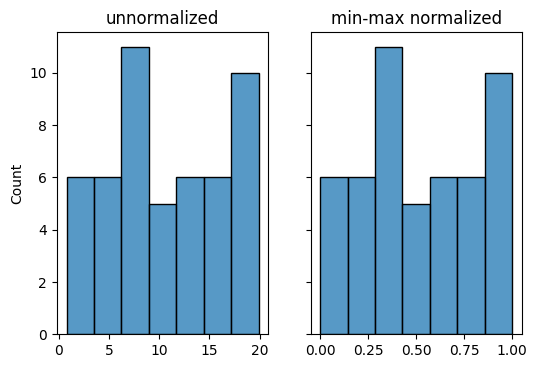

In [ ]:
#  visualising distribution
figure, axes = plt.subplots(1, 2, sharey=True, dpi=100)
sns.histplot(data, ax=axes[0])
axes[0].set_title('unnormalized')
sns.histplot(normalized, ax=axes[1])
axes[1].set_title('min-max normalized')

In [ ]:
def z_score_normalize(data_points: np.array):
  """
  This function normalizes data by computing
  their z-scores  
  """
  #  convert list to numpy array
  if type(data_points) == list:
    data_points = np.array(data_points)
  else:
    pass

  #  create a list to hold normalized data
  normalized = []

  #  derive mean and and standard deviation
  mean = data_points.mean()
  std = data_points.std()

  #  convert to list for iteration
  data_points = list(data_points)
  #  normalizing data
  for value in data_points:
    normalize = (value-mean)/std
    normalized.append(round(normalize, 2))
  
  return np.array(normalized)

In [ ]:
#  normalizing data points
z_normalized = z_score_normalize(data)

#  check the mean value
z_normalized.mean()
-0.0006

#  check the standard deviation
z_normalized.std()
1.0000

1.0

Text(0.5, 1.0, 'z-score normalized')

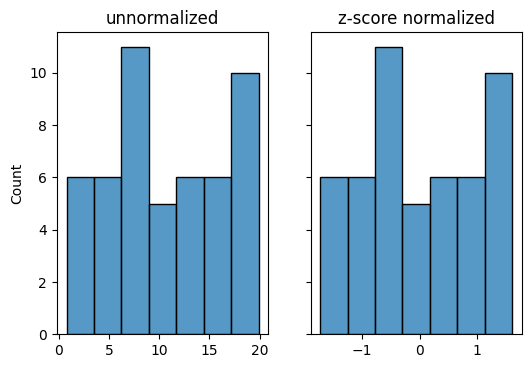

In [ ]:
#  visualizing distributions
figure, axes = plt.subplots(1, 2, sharey=True, dpi=100)
sns.histplot(data, ax=axes[0])
axes[0].set_title('unnormalized')
sns.histplot(z_normalized, ax=axes[1])
axes[1].set_title('z-score normalized')

In [ ]:
#  loading training data
training_set = Datasets.MNIST(root='./', download=True,
                              transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Resize((32, 32))]))

#  loading validation data
validation_set = Datasets.MNIST(root='./', download=True, train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Resize((32, 32))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
class ConvolutionalNeuralNet():
  def __init__(self, network):
    self.network = network.to(device)
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  defining accuracy function
    def accuracy(network, dataloader):
      network.eval()
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(network(images), dim=1)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      return round(total_correct/total_instances, 3)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)

    #  setting convnet to training mode
    self.network.train()

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      for images, labels in tqdm(train_loader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        self.optimizer.zero_grad()
        #  making predictions
        predictions = self.network(images)
        #  computing loss
        loss = loss_function(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        self.optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(self.network, train_loader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      self.network.eval()

      with torch.no_grad():
        for images, labels in tqdm(val_loader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = self.network(images)
          #  computing loss
          val_loss = loss_function(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(self.network, val_loader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')
      
    return log_dict

  def predict(self, x):
    return self.network(x)

In [ ]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool1 = nn.AvgPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.AvgPool2d(2)
    self.linear1 = nn.Linear(5*5*16, 120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn. Linear(84, 10)

  def forward(self, x):
    x = x.view(-1, 1, 32, 32)

    #----------
    # LAYER 1
    #----------
    output_1 = self.conv1(x)
    output_1 = torch.tanh(output_1)
    output_1 = self.pool1(output_1)
    
    #----------
    # LAYER 2
    #----------
    output_2 = self.conv2(output_1)
    output_2 = torch.tanh(output_2)
    output_2 = self.pool2(output_2)
    
    #----------
    # FLATTEN
    #----------
    output_2 = output_2.view(-1, 5*5*16)

    #----------
    # LAYER 3
    #----------
    output_3 = self.linear1(output_2)
    output_3 = torch.tanh(output_3)
    
    #----------
    # LAYER 4
    #----------
    output_4 = self.linear2(output_3)
    output_4 = torch.tanh(output_4)
    
    #-------------
    # OUTPUT LAYER
    #-------------
    output_5 = self.linear3(output_4)
    return(F.softmax(output_5, dim=1))

In [ ]:
#  training model 1
model_1 = ConvolutionalNeuralNet(LeNet5())

log_dict_1 = model_1.train(nn.CrossEntropyLoss(), epochs=10, batch_size=64, 
                       training_set=training_set, validation_set=validation_set)

Epoch 1/10
training...


  0%|          | 0/938 [00:00<?, ?it/s]

deriving training accuracy...


  0%|          | 0/938 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

deriving validation accuracy...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 1.5807  training_accuracy: 0.947  validation_loss: 1.5203 validation_accuracy: 0.946

Epoch 2/10
training...


  0%|          | 0/938 [00:00<?, ?it/s]

deriving training accuracy...


  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
sns.lineplot(y=log_dict_1['training_accuracy_per_epoch'], x=range(len(log_dict_1['training_accuracy_per_epoch'])), label='training')

sns.lineplot(y=log_dict_1['validation_accuracy_per_epoch'], x=range(len(log_dict_1['validation_accuracy_per_epoch'])), label='validation')

plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
class LeNet5_BatchNorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.batchnorm1 = nn.BatchNorm2d(6)
    self.pool1 = nn.AvgPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.batchnorm2 = nn.BatchNorm2d(16)
    self.pool2 = nn.AvgPool2d(2)
    self.linear1 = nn.Linear(5*5*16, 120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn. Linear(84, 10)

  def forward(self, x):
    x = x.view(-1, 1, 32, 32)

    #----------
    # LAYER 1
    #----------
    output_1 = self.conv1(x)
    output_1 = torch.tanh(output_1)
    output_1 = self.batchnorm1(output_1)
    output_1 = self.pool1(output_1)
    
    #----------
    # LAYER 2
    #----------
    output_2 = self.conv2(output_1)
    output_2 = torch.tanh(output_2)
    output_2 = self.batchnorm2(output_2)
    output_2 = self.pool2(output_2)
    
    #----------
    # FLATTEN
    #----------
    output_2 = output_2.view(-1, 5*5*16)

    #----------
    # LAYER 3
    #----------
    output_3 = self.linear1(output_2)
    output_3 = torch.tanh(output_3)
    
    #----------
    # LAYER 4
    #----------
    output_4 = self.linear2(output_3)
    output_4 = torch.tanh(output_4)
    
    #-------------
    # OUTPUT LAYER
    #-------------
    output_5 = self.linear3(output_4)
    return(F.softmax(output_5, dim=1))

In [ ]:
#  training model 2
model_2 = ConvolutionalNeuralNet(LeNet5_BatchNorm())

log_dict_2 = model_2.train(nn.CrossEntropyLoss(), epochs=10, batch_size=64, 
                       training_set=training_set, validation_set=validation_set)

In [ ]:
sns.lineplot(y=log_dict_2['training_accuracy_per_epoch'], x=range(len(log_dict_2['training_accuracy_per_epoch'])), label='training')

sns.lineplot(y=log_dict_2['validation_accuracy_per_epoch'], x=range(len(log_dict_2['validation_accuracy_per_epoch'])), label='validation')

plt.xlabel('epoch')
plt.ylabel('accuracy')